# Imports, dataloading

In [6]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True
# Colors
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
c_leg = '0.5'


In [7]:
#@title Data retrieval and loading
#@markdown To load, call `load_data(<dset_name>)` with
#@markdown `dset_names in ["faceshouses", "motor_imagery",
#@markdown "memory_nback", "fingerflex", "joystick_track"]`.

#@markdown See dataset-specific notebooks for details.

#@markdown Decide whether you want to work only in memory, or save files.

#@markdown **TBD: Loading with temporary file has a bug!**
save_file = True

import requests
from tqdm.notebook import tqdm, trange
from tempfile import TemporaryFile, TemporaryDirectory
from math import ceil
from pathlib import Path
import numpy as np

def retrieve(url, fname=None):
  chunk_size = 8196
  tmpdir = TemporaryDirectory()
  if fname is None:
    file_name = Path(tmpdir)/'temp.npz'
  else:
    file_name = Path(fname)
  if not file_name.is_file():
    with open(file_name, 'wb') as fid:
      try:
        with requests.get(url, stream=True) as r:
          assert r.status_code == requests.codes.ok, "!!! Failed to download data !!!"
          with tqdm(
              total=ceil(int(r.headers['Content-Length'])),
              unit='B',
              unit_scale=True,
              unit_divisor=1024
          ) as pbar:
            for chunk in r.iter_content(chunk_size=chunk_size):
              fid.write(chunk)
              pbar.update(chunk_size)
      except requests.ConnectionError:
        print("Connection failed!")
  return np.load(file_name, allow_pickle=True)

def load_data(dset_name, patient_id=0, **kwargs):
    dset_urls = {
        "faceshouses":    "https://osf.io/argh7/download",
        "motor_imagery":  "https://osf.io/ksqv8/download",
        "memory_nback":   "https://osf.io/xfc7e/download",
        "fingerflex":     "https://osf.io/5m47z/download",
        "joystick_track": "https://osf.io/6jncm/download",
    }
    assert dset_name in dset_urls.keys(), (
        "possible `dset_name`s: " + "".join([dsn + ", " for dsn in dset_urls.keys()])
        )
    url = dset_urls[dset_name]
    if save_file:
        fname = dset_name + ".npz"
    else:
        fname = None
    alldat = retrieve(url, fname)['dat']
    assert patient_id < len(alldat), "Max patient_id is %d for %s" % (
        len(alldat), dset_name)
    # Dataset-specific variable assignment
    # This is done to be in line with the other colab notebooks.
    if dset_name in ['faceshouses', 'motor_imagery']:
        dat1 = alldat[patient_id][0]
        dat2 = alldat[patient_id][1]
        return dat1, dat2
    elif dset_name == 'memory_nback':
        # Choose a specific block
        if "block_id" in kwargs.keys():
            block_id = kwargs["block_id"]
        else:
            block_id = 0
        dat = alldat[patient_id][block_id]
        return dat
    elif dset_name in ['fingerflex', 'joystick_track']:
        dat = alldat[patient_id]
        return dat

# # Test
# dset_names = ["faceshouses", "motor_imagery", "memory_nback", "fingerflex",
#               "joystick_track"]
# for dset_name in dset_names:
#     load_data(dset_name)


#TBD: Electrode positions # Eis is on it

In [8]:
!pip install mne --quiet
!pip install nilearn --quiet
!pip install nimare --quiet
!pip install duecredit --quiet

from nilearn import plotting
from nimare import utils

# Choose dataset
url = "https://osf.io/argh7/download"
fname ="faceshouses.npz"
alldat =  retrieve(url, fname)['dat']

# Plot electrode locations
plt.figure(figsize=(8, 8))
locs = dat1['locs']
view = plotting.view_markers(utils.tal2mni(locs),
                             marker_labels=['%d'%k for k in np.arange(locs.shape[0])],
                             marker_color='purple',
                             marker_size=5)
view

NameError: ignored

<Figure size 800x800 with 0 Axes>

# Visualize voltage traces

In [ ]:
#@title Load data and define variables
# Load voltage dataset
# Here we choose data from faceshouses, patient 1
dat1, _ = load_data('faceshouses', patient_id=1)

# Define variables
# Voltage data: times x channel
V = dat1['V']
n_t, n_ch = V.shape
channels = np.arange(n_ch)
# Times
srate = dat1['srate'].squeeze()
t_all = np.arange(n_t) #/ srate
t_on = dat1['t_on'] #/ srate
t_off = dat1['t_off'] #/ srate
# print("Min and max time / s:", t_all.min(), t_all.max())
# Stimulus identities
n_stim = len(t_on)
stim_id = dat1['stim_id']
n_stim_id = stim_id.max() - stim_id.min()
# 1-50 for houses, 51-100 for faces
n_stim_g = n_stim_id//2 + 1
id_max_house = 50

<ipython-input-48-e243972ef316>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels((ax.get_xticks()*1e-3))


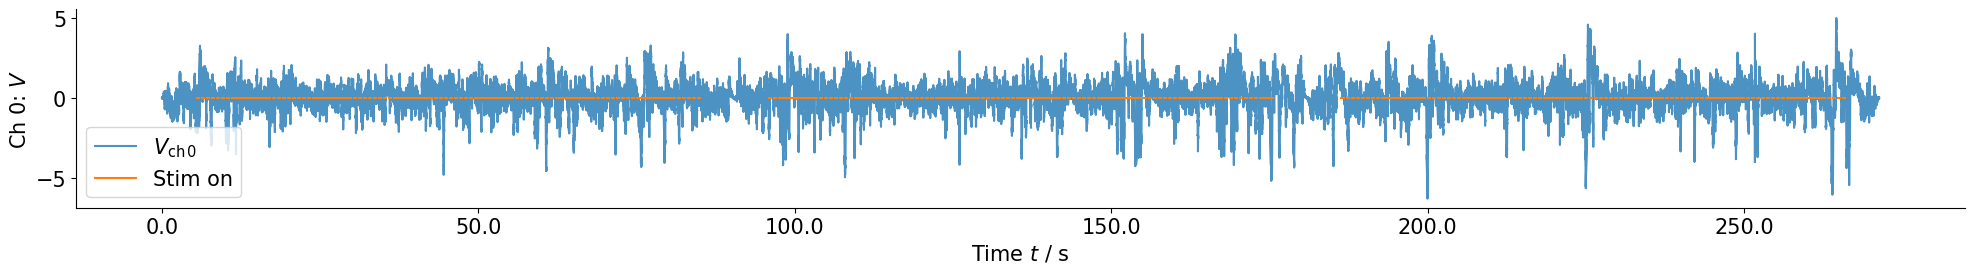

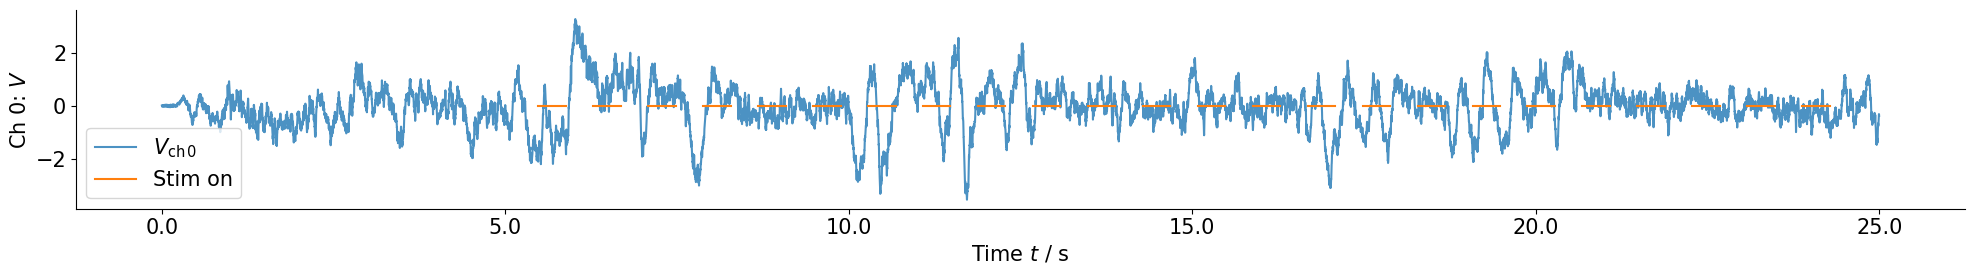

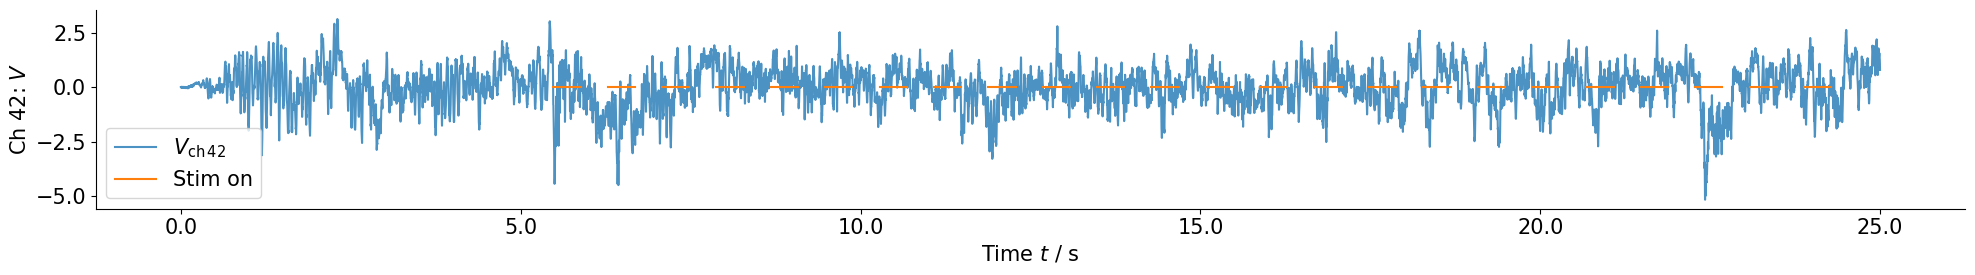

In [ ]:
#@title Plot single channels
def plot_one_channel(i_ch=42, t_min_show=0, t_max_show=25e3):   # you can change the channel number here
    """ Plot all the data for one channel."""
    fig = plt.figure(figsize=(20, 3))
    ax = fig.subplots(1, 1)

    # Choose time window
    if t_min_show is None:
        t_min_show = t_all[0]
    if t_max_show is None:
        t_max_show = t_all[-1]
    mask = (t_all >= t_min_show) * (t_all < t_max_show)
    mask_oo = (t_on >= t_min_show) * (t_off < t_max_show)

    ax.plot(t_all[mask], V[mask][:, i_ch], c=colors[0], alpha=0.8,
            label="$V_{\mathrm{ch}\,%d}$" %(i_ch))
    # Add stimulus on-off
    for i_t, (t_on_i, t_off_i) in enumerate(
        zip(t_on[mask_oo], t_off[mask_oo])):
        t_oo = np.array([t_on_i, t_off_i])
        ax.plot(t_oo, np.zeros_like(t_oo), color=colors[1],
                label="Stim on" if i_t==0 else None)
    ax.legend(loc=3)
    ax.set_xticklabels((ax.get_xticks()*1e-3))
    ax.set_xlabel('Time $t$ / s')
    ax.set_ylabel('Ch %d: $V$' % i_ch)

plot_one_channel(i_ch=0, t_max_show=None)
plot_one_channel(i_ch=0)
plot_one_channel(i_ch=42)


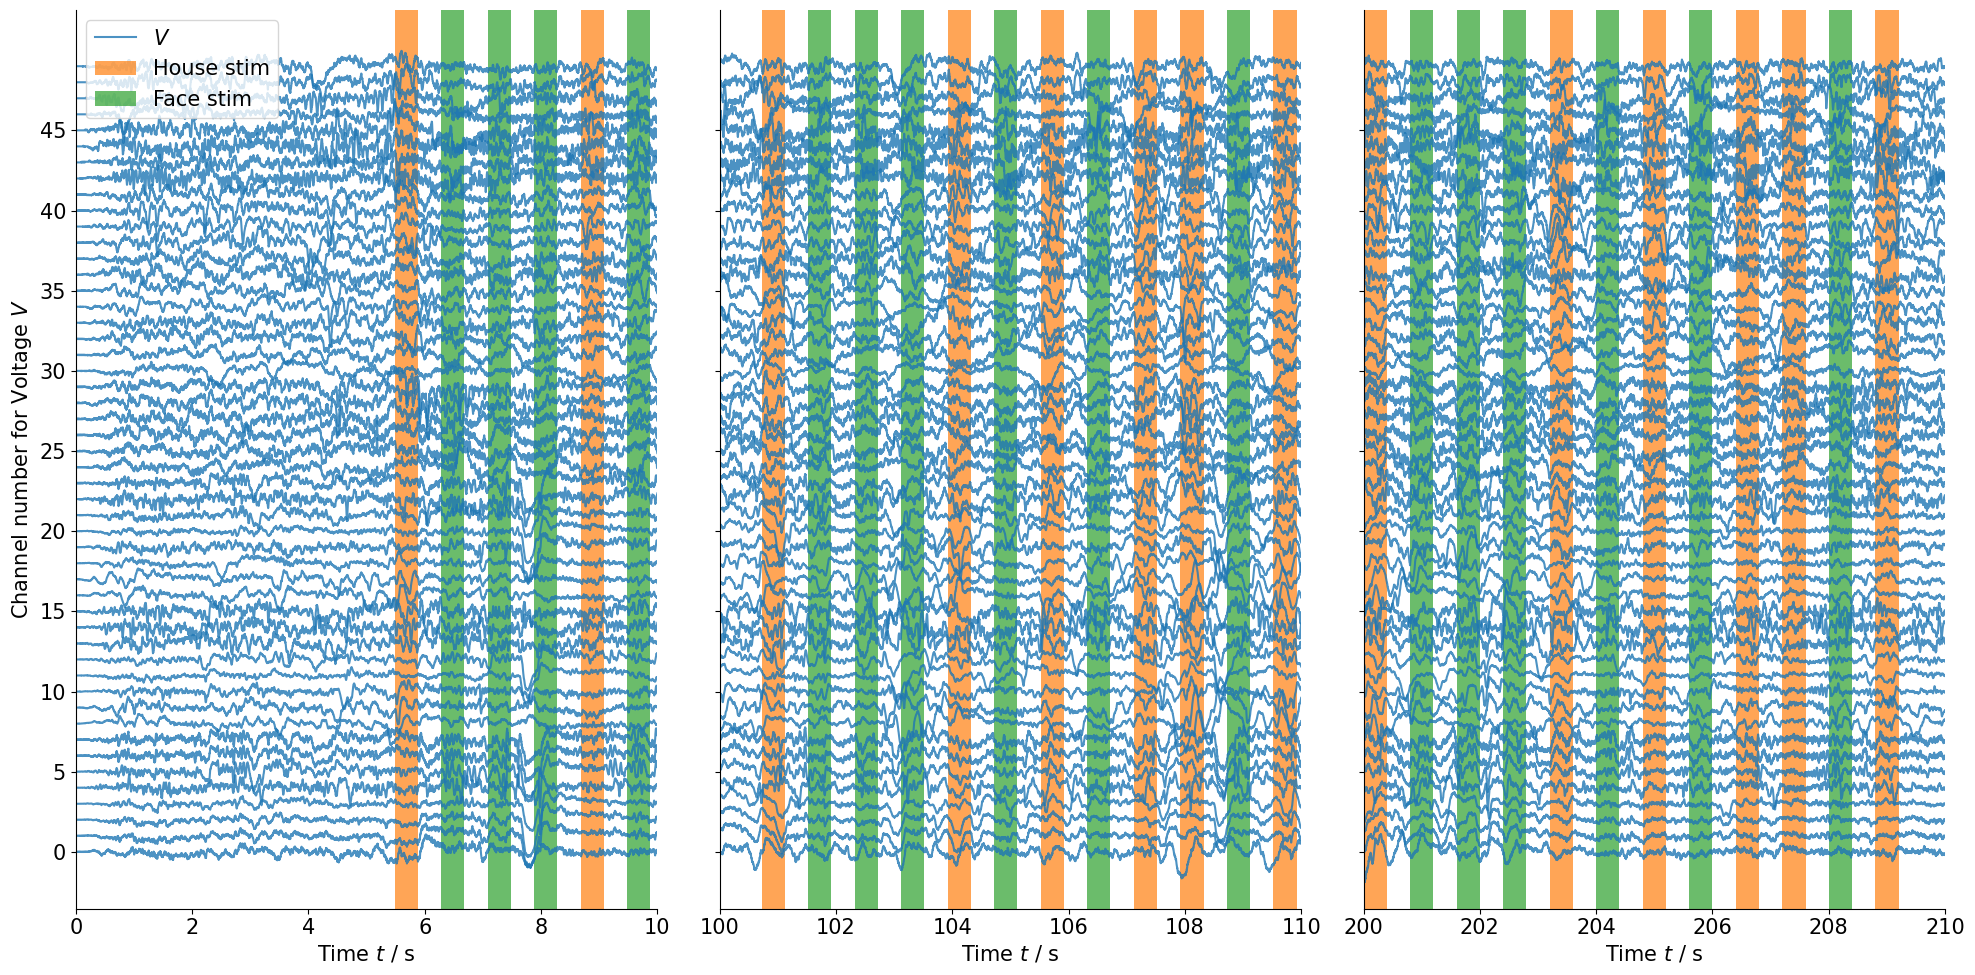

In [ ]:
#@title Plot all channels
def plot_time_windows(ch_clusters=None):
    """ Plot smaller time windows, but all channels.
    """
    # Define 3 time windows in ms
    t_min_shows = np.array([0, 100, 200]) * 1e3       # create an array of three time windows and their start times; convert time to millisecond
    dt = 10 * 1e3                                     # duration of each time window
    t_max_shows = t_min_shows + dt                    # create an array of three time windows and their end times
    n_t_show = len(t_min_shows)                       # this is the total number of time windows for the plot

    fig = plt.figure(figsize=(20, 10))
    n_cols = n_t_show
    axes = fig.subplots(1, n_t_show)                   # create 3 subplots in a 1 x n_t_show grid
    for i_c in range(n_t_show):
        ax = axes[i_c]
        # Choose time to be shown
        t_min_show = t_min_shows[i_c]
        t_max_show = t_max_shows[i_c]
        mask = (t_all >= t_min_show) * (t_all < t_max_show)     # mask indicates which data points are within the time window
        mask_oo = (t_on >= t_min_show) * (t_off < t_max_show)   # this indicates which data points are within the onset and offset windows

        # Show voltage traces
        offset = 3                                        # this is just the spacing between voltage traces in the plot
        if ch_clusters is None:                           # clustering is done in later cells (see below), so only voltage traces of all channels are plotted
            n_ch_show = n_ch
            for i_ch in range(n_ch_show):
                ax.plot(t_all[mask], V[mask, i_ch] + i_ch * offset, c=colors[0], alpha=0.8,
                        label="$V$" if i_ch==0 else None)
        else:
            # Sorted traces by clusters
            V_off = 0
            tickloc = []
            ticklbl = []
            for i_cl, ch_cluster in enumerate(ch_clusters):
                lbl_V = True
                c = colors[i_cl]
                for i_ch in ch_cluster:
                    lbl = r"$V_{\mathrm{Cluster %d}}$" % (i_cl) if lbl_V else None
                    lbl_V = False
                    ax.plot(t_all[mask], V[mask, i_ch] + V_off, c=c, alpha=0.8,
                            label=lbl)
                    tickloc.append(V_off)
                    ticklbl.append(i_ch)

                    V_off += offset
                V_off += 2 * offset

        # Show stimuli.
        # For this, we shade the times when a stimulus is on. Use a color scheme
        # to identify the stimulus.
        lbl_h = True
        lbl_f = True
        for i_t, (t_on_i, t_off_i) in enumerate(
            zip(t_on[mask_oo], t_off[mask_oo])):
            # Color indicates stimulus id:
            is_house = stim_id[i_t] <= id_max_house
            if is_house:
                lbl = 'House stim' if lbl_h else None
                lbl_h = False
            else:
                lbl = 'Face stim' if lbl_f else None
                lbl_f = False

            if ch_clusters is None:
                hatch = None
                c = colors[1] if is_house else colors[2]
            else:
                c = '0.5'
                hatch = "///" if is_house else "\\"
            ax.axvspan(t_on_i, t_off_i, facecolor=c, hatch=hatch,
                       edgecolor='k', lw=0,
                       alpha=0.7, zorder=-1, label=lbl)

        # Some polishing
        if i_c == 0:
            ax.legend(loc=2)
        # y-axis
        if i_c == 0:
            ymin, ymax = ax.get_ylim()
        ax.set_ylim(ymin, ymax)
        if ch_clusters is None:
            ytl = np.arange(0, n_ch_show, 5)
            ax.set_yticks(ytl*offset)
            if i_c == 0:
                ax.set_yticklabels(ytl)
                ax.set_ylabel('Channel number for Voltage $V$')
            else:
                ax.set_yticklabels([])
        else:
            if i_c == 0:
                ax.set_ylabel('Clustered voltage channels')
                ax.set_yticks(tickloc)
                ax.set_yticklabels(ticklbl, fontsize=11)
            else:
                ax.set_yticklabels([])
        # x-axis
        ax.set_xlim(t_min_show, t_max_show)
        xticks = ax.get_xticks()
        ax.set_xticks(xticks)
        ax.set_xticklabels(np.int_(xticks*1e-3))
        ax.set_xlabel('Time $t$ / s')
plot_time_windows()


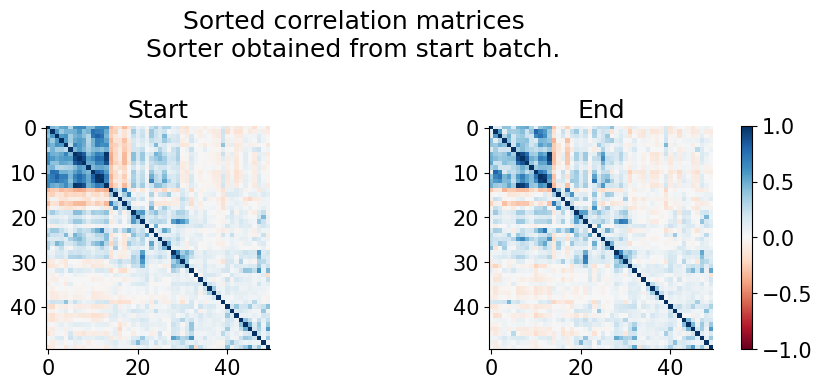

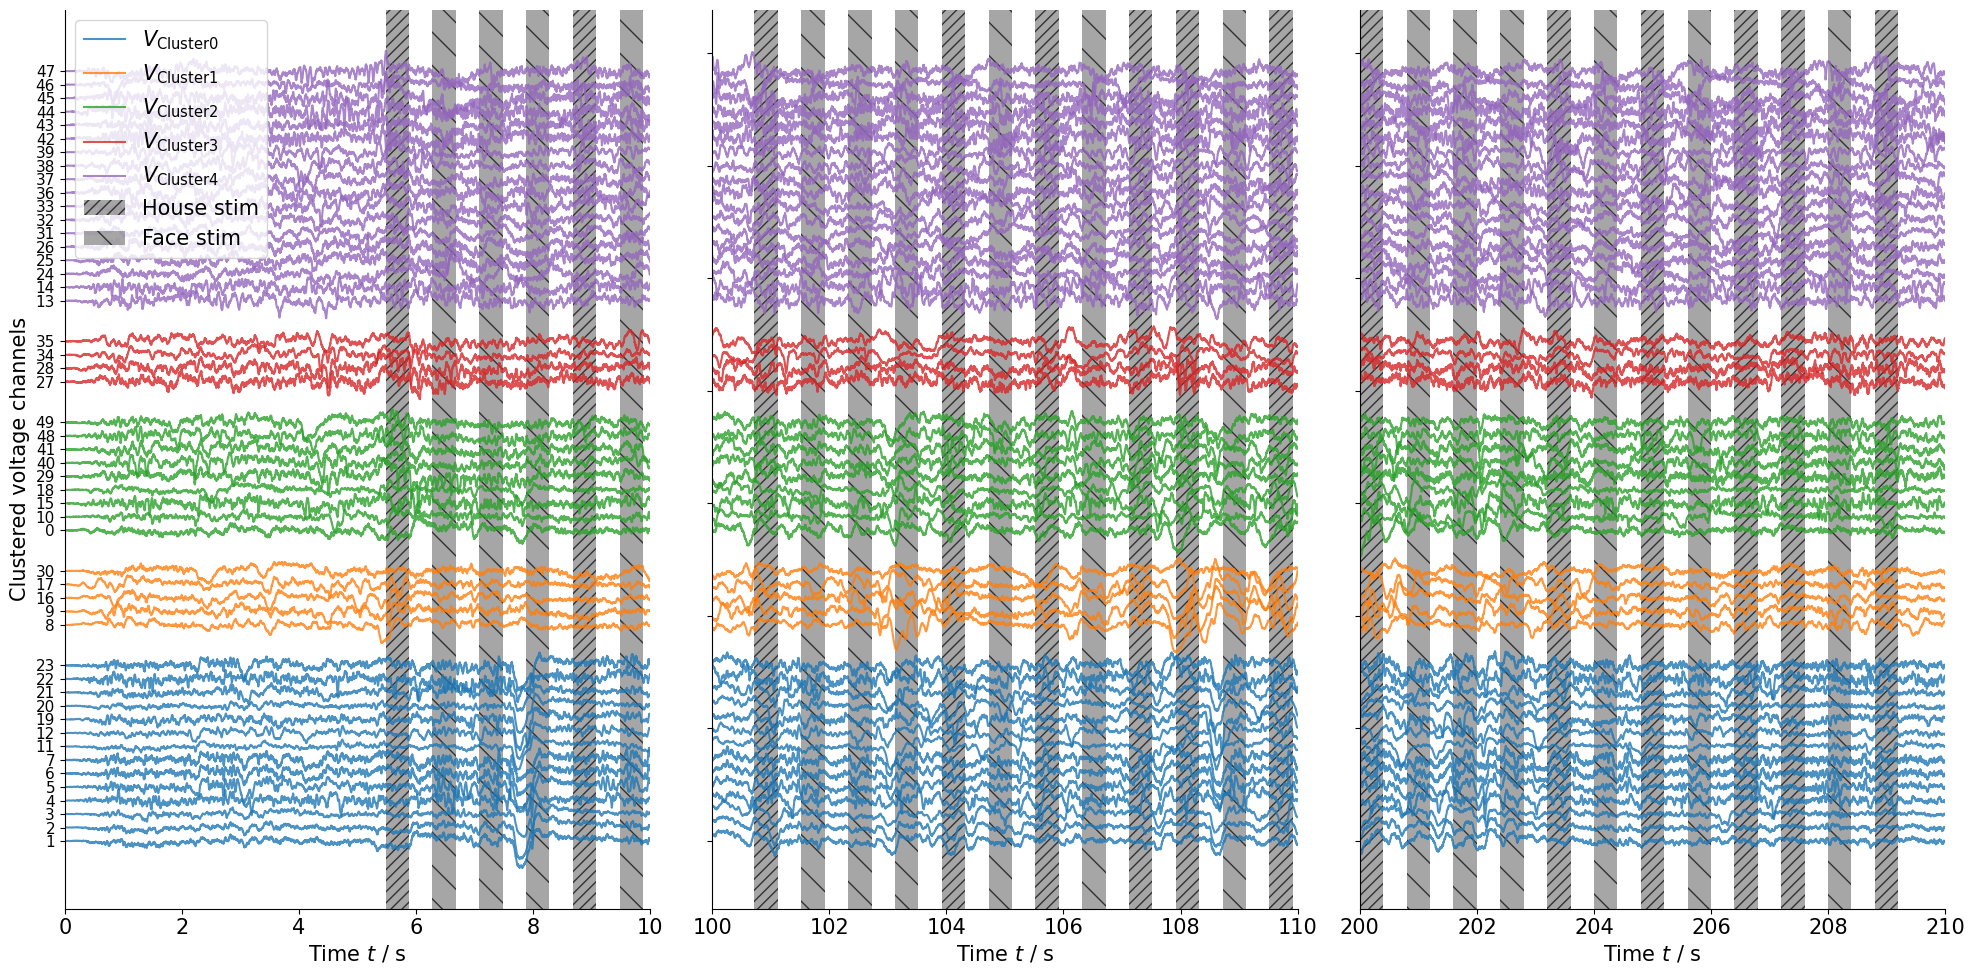

In [ ]:
#@title Cluster channels with cross correlation

# Subsampling for ease on memory?
step = 10         # this subsamples the data in a step size of 10

# Choose time window (restrict analysis to a specific time period)
dt = 75 * 1e3
t_mins = np.array([t_on[0], t_off[-1]-dt])
t_maxs = t_mins + dt
n_cov = len(t_mins)

corr_all = np.zeros((n_cov, n_stim_g, n_stim_g))
for i_c in range(n_cov):                  # loop through time windows
    t_min = t_mins[i_c]                   # for each time window, get the start and end times
    t_max = t_maxs[i_c]
    mask = (t_all >= t_min) * (t_all < t_max)   # mask to indicate which data points are within the time window
    Vw = np.float_(V[mask][::step])             # data is subsampled using step=10
    Vw_sq = (Vw**2).sum(0)                      # calculate the variance of the data
    cov = (Vw[:, :, None] * Vw[:, None, :]).sum(0)      # calculate the covariance of the data. Covariance is a measure of how similar two signals are
    corr = cov / np.sqrt(Vw_sq[:, None] * Vw_sq[None, :])   # calculate the correlation. Correlation is covariance normalized by the variance of the signal
    corr_all[i_c] = corr                        # 2D array stores correlation data; time window x stim ID

# Cluster channels according to correlation
# Use the first matrix to cluster (first time window; training set); the second is for validation (second time window; test set)
# If the two matrices look similar, then the clustering is robust
corr = corr_all[0]

# Sort matrix by clusters.
# Based on: https://wil.yegelwel.com/cluster-correlation-matrix/
import scipy
import scipy.cluster.hierarchy as sch                 # this library has functions for hierarchical clustering
pairwise_distances = sch.distance.pdist(corr)         # the distance between two channels is a measure of how similar the channels are
linkage = sch.linkage(pairwise_distances, method='complete')      # linkage matrix is a hierarchical clustering of channels
cluster_distance_threshold = pairwise_distances.max()/2           # this threshold determines which channels belong in the same cluster
idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold,
                                    criterion='distance')         # this array indicates which cluster each channel belongs to
cl_sorter = np.argsort(idx_to_cluster_array)                      # channels are sorted according to cluster using cluster ID
# Obtain channel ids in each cluster
clusters = np.unique(idx_to_cluster_array)                        # loop through the unique cluster IDs
ch_clusters = []
for cl in clusters:                                               # for each cluster ID, get channel IDs that belong to each cluster
    cl_idx = np.where(idx_to_cluster_array == cl)[0]
    ch_clusters.append(channels[cl_idx])
n_cl = len(ch_clusters)                                           # 2D list (cluster ID, channel ID)

# Plot clustering
fig = plt.figure(figsize=(10, 4))
axes = fig.subplots(1, n_cov)
for i_c in range(n_cov):
    ax = axes[i_c]
    corr = corr_all[i_c]
    corr_s = corr[cl_sorter, :][:, cl_sorter]
    im = ax.imshow(corr_s, cmap="RdBu", vmin=-1, vmax=1)
    if i_c == n_cov-1:
        plt.colorbar(im)
    lbl = ["Start", "End"][i_c]
    ax.set_title(lbl)
fig.suptitle("Sorted correlation matrices\nSorter obtained from start batch.")

plot_time_windows(ch_clusters)

<ipython-input-51-029882f766cd>:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels((ax.get_xticks()*1e-3))


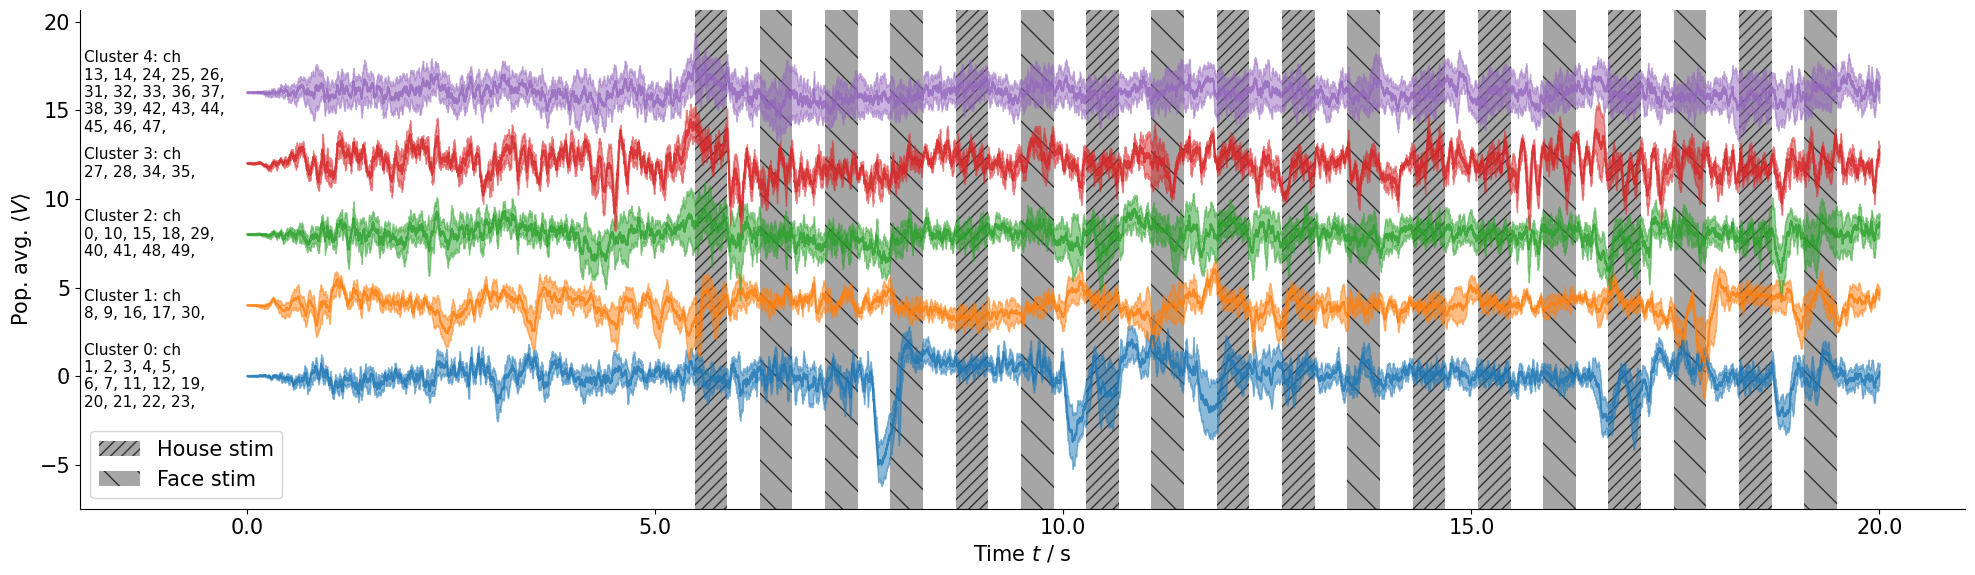

In [ ]:
#@title Plot cluster averages
def plot_pop_avg(t_min_show=0, t_max_show= 40 * 1e3, ch_clusters=None):
    if ch_clusters is None:
        fig = plt.figure(figsize=(20, 3))
    else:
        fig = plt.figure(figsize=(20, 6))
    ax = fig.subplots(1, 1)
    # Choose time window
    mask = (t_all >= t_min_show) * (t_all < t_max_show)
    mask_oo = (t_on >= t_min_show) * (t_off < t_max_show)

    if ch_clusters is None:
        V_cl = V[mask]
        V_clm = V_cl.mean(1)
        V_cls = V_cl.std(1)
        ax.plot(t_all[mask], V_clm, alpha=0.8,
                label=r"$\langle V\rangle$")
        ax.fill_between(t_all[mask], V_clm - V_cls, V_clm + V_cls,
                        alpha=0.5)
    else:
        # Sorted traces by clusters
        offset = 4
        for i_cl, ch_cluster in enumerate(ch_clusters):
            c = colors[i_cl]
            V_off = offset * i_cl
            V_cl = V[mask][:, ch_cluster] + V_off
            V_clm = V_cl.mean(1)
            V_cls = V_cl.std(1)
            ax.plot(t_all[mask], V_clm, c=c, alpha=0.8)
            ax.fill_between(t_all[mask], V_clm - V_cls, V_clm + V_cls,
                            color=c, alpha=0.5)
            # Indicate clusters
            lbl = "Cluster %d: ch\n" %i_cl
            for ii, i_ch in enumerate(ch_cluster):
                lbl += "%d, " % i_ch
                if ii %5 == 4: lbl += "\n"
            lbl = lbl[:-1]
            dt = (t_max_show - t_min_show)
            y = t_min_show - dt/10
            ax.text(y, V_off, lbl, ha='left', va='center', fontsize=11)
            ax.plot(t_min_show-dt/20, 0, '-')

    # Show stimuli.
    # For this, we shade the times when a stimulus is on. Use a color scheme
    # to identify the stimulus.
    lbl_h = True
    lbl_f = True
    for i_t, (t_on_i, t_off_i) in enumerate(
        zip(t_on[mask_oo], t_off[mask_oo])):
        # Color indicates stimulus id:
        is_house = stim_id[i_t] <= id_max_house
        if is_house:
            lbl = 'House stim' if lbl_h else None
            lbl_h = False
        else:
            lbl = 'Face stim' if lbl_f else None
            lbl_f = False

        if ch_clusters is None:
            hatch = None
            c = colors[1] if is_house else colors[2]
        else:
            c = '0.5'
            hatch = "///" if is_house else "\\"

        ax.axvspan(t_on_i, t_off_i, facecolor=c, hatch=hatch,
                   edgecolor='k', lw=0,
                   alpha=0.7, zorder=-1, label=lbl)

    ax.legend(loc=3)
    ax.set_xticklabels((ax.get_xticks()*1e-3))
    ax.set_xlabel('Time $t$ / s')
    ax.set_ylabel(r'Pop. avg. $\langle V \rangle$')

plot_pop_avg(0, 20e3, ch_clusters=ch_clusters)

In PCA analysis, a scree plot is a graph that shows the eigenvalues as a function of the principal component number. The eigenvalues represent the amount of variance explained by each principal component.

A scree plot is not informative if it does not show a clear elbow or bend. This means that there is no clear point where the eigenvalues start to decrease significantly.  It could mean that signals are not low-dimensional -- the signals cannot be explained by a small number of principal components.

Text(0.5, 0.98, 'PCA results for clusters (with # channels)\nIn a nutshell: signals are not low-D')

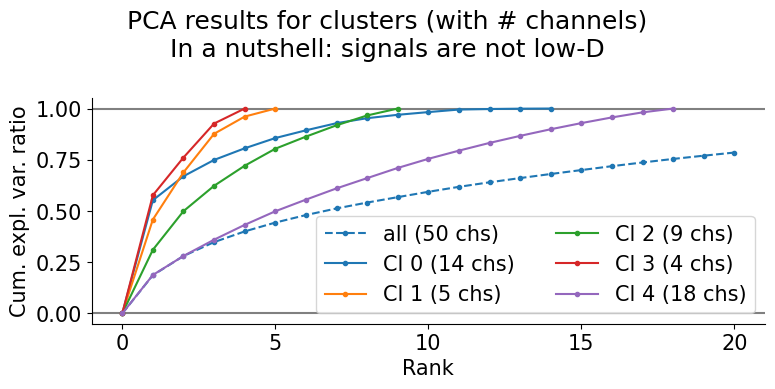

In [ ]:
#@title PCA per cluster (not very informative)
from sklearn.decomposition import PCA
# Full PCA
n_comp = 20
pca = PCA(n_comp)
pca.fit(V)
cevr_V = pca.explained_variance_ratio_.cumsum()
cevr_V = np.r_[0, cevr_V]
rank = np.arange(len(cevr_V))

# PCA for each cluster
cevr_cl = np.zeros((n_cl, ), dtype=object)
for i_cl in range(n_cl):
    ch_cl = ch_clusters[i_cl]
    V_cl = V[:, ch_cl]
    n_comp_cl = min(n_comp, len(ch_cl))
    pca = PCA(n_comp_cl)
    pca.fit(V_cl)
    cevr_cl_i = pca.explained_variance_ratio_.cumsum()
    cevr_cl[i_cl] = np.r_[0, cevr_cl_i]

# Plot
fig = plt.figure(figsize=(8, 4))
ax = fig.subplots(1, 1)
ax.plot(cevr_V, '.--', label="all (%d chs)" %(n_ch))
for i_cl in range(n_cl):
    c = colors[i_cl]
    n_ch_cl = len(ch_clusters[i_cl])
    ax.plot(cevr_cl[i_cl], '.-', c=c, label="Cl %d (%d chs)" % (i_cl, n_ch_cl))
ax.legend(loc=4, ncol=2)
ax.set_xticks(rank[::5])
ax.set_xlabel("Rank")
ax.set_ylabel("Cum. expl. var. ratio")
ax.axhline(0, c='0.5', zorder=-1)
ax.axhline(1, c='0.5', zorder=-1)
fig.suptitle("PCA results for clusters (with # channels)\nIn a nutshell: signals are not low-D")

#Signal processing

In [ ]:
#@title Load data and define variables
# Load voltage dataset (e.g. faces house)
dat1, _ = load_data('faceshouses', patient_id=1)

# Define variables
# Voltage data: times x channel
V = dat1['V']
n_t, n_ch = V.shape
channels = np.arange(n_ch)
# Times
srate = dat1['srate'].squeeze()
t_all = np.arange(n_t) #/ srate
t_on = dat1['t_on'] #/ srate
t_off = dat1['t_off'] #/ srate
# print("Min and max time / s:", t_all.min(), t_all.max())
# Stimulus identities
n_stim = len(t_on)
stim_id = dat1['stim_id']
n_stim_id = stim_id.max() - stim_id.min()
# 1-50 for houses, 51-100 for faces
n_stim_g = n_stim_id//2 + 1
id_max_house = 50

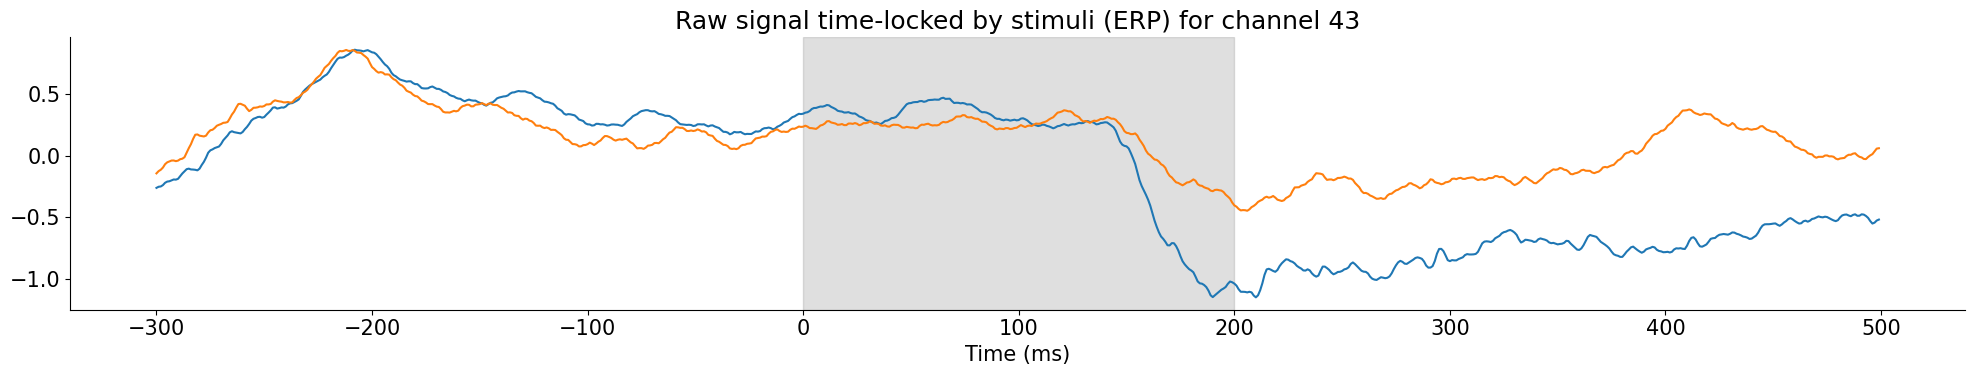

ERP decomposed into delta, theta, alpha, beta, and gamma bands for channel 43


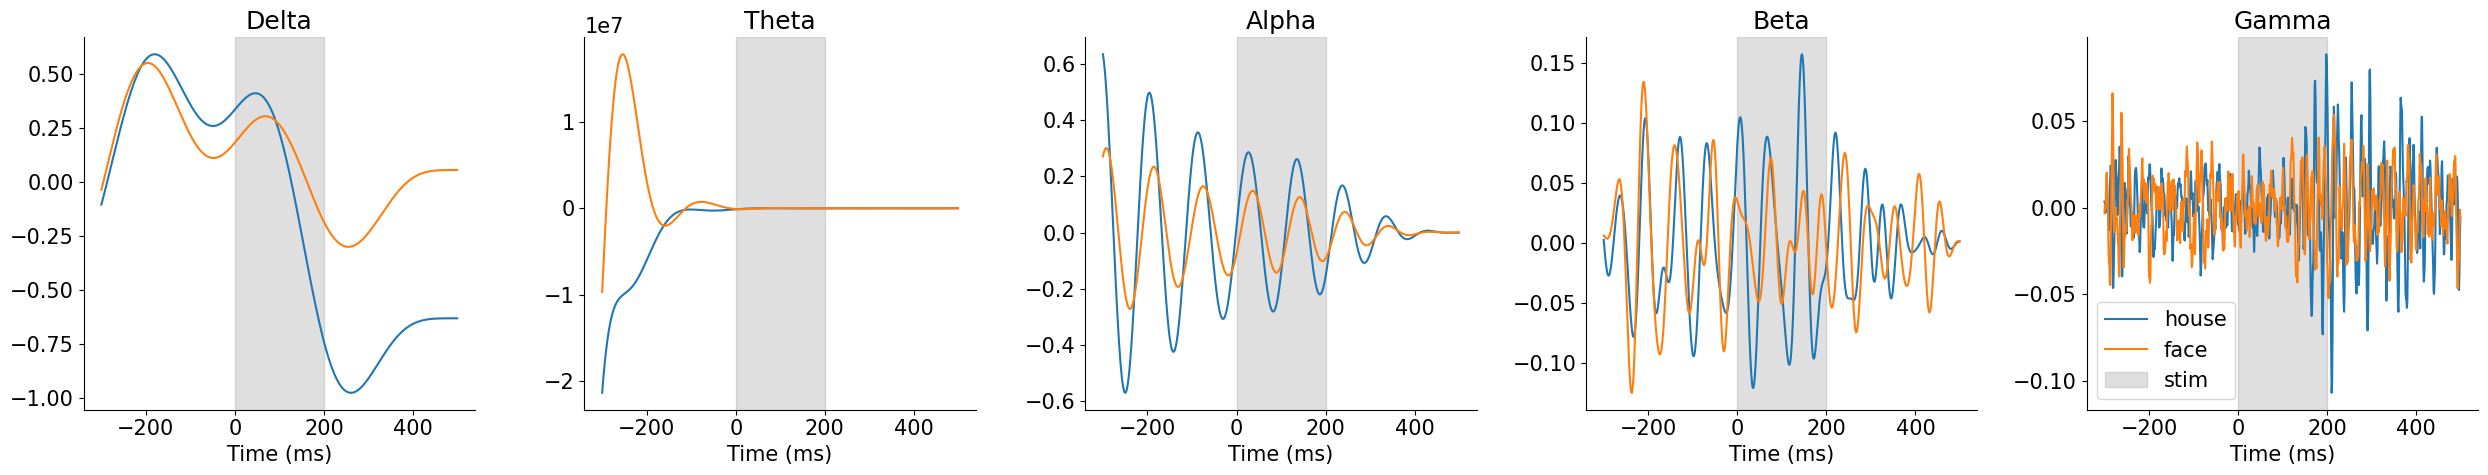

In [ ]:
#@title Filtering signal into specific frequency ranges
#@markdown After finding the ERP, some filters are applied to only let specific frequency ranges to pass. Notice that by calculating the ERP, you are probably averaging out important frequency-specific signals, so it might be better to apply the filters in the raw signal before averging it out, and then time-lock it.

from scipy import signal

channel_ID = 43

# Find number of stimuli nstim
nstim = len(dat1['t_on'])

# Find event-locked signal
trange = np.arange(-300, 500)
ts = dat1['t_on'][:,np.newaxis] + trange
V_epochs = np.reshape(V[ts, channel_ID], (nstim, 800, 1))

# Split into houses and faces stimuli and find ERP.
V_house = (V_epochs[dat1['stim_id']<=50]).mean(0)
V_face  = (V_epochs[dat1['stim_id']>50]).mean(0)

plt.title('Raw signal time-locked by stimuli (ERP) for channel '+str(channel_ID))
plt.plot(trange,V_house,label='house')
plt.plot(trange,V_face,label='face')
plt.axvspan(0,200, color='0.5', alpha=0.25)
plt.xlabel('Time (ms)')
plt.show()

# Filter into delta, theta, alpha, beta, and gamma bands
b, a = signal.butter(5, [4], btype = 'low', fs=1000)
V_house_delta = signal.filtfilt(b,a,V_house,0)
V_face_delta = signal.filtfilt(b,a,V_face,0)

b, a = signal.butter(5, [4,8], btype = 'bandpass', fs=1000)
V_house_theta = signal.filtfilt(b,a,V_house,0)
V_face_theta = signal.filtfilt(b,a,V_face,0)

b, a = signal.butter(5, [8,12], btype = 'bandpass', fs=1000)
V_house_alpha = signal.filtfilt(b,a,V_house,0)
V_face_alpha = signal.filtfilt(b,a,V_face,0)

b, a = signal.butter(5, [12,30], btype = 'bandpass', fs=1000)
V_house_beta = signal.filtfilt(b,a,V_house,0)
V_face_beta = signal.filtfilt(b,a,V_face,0)

b, a = signal.butter(5, [30], btype = 'high', fs=1000)
V_house_gamma = signal.filtfilt(b,a,V_house,0)
V_face_gamma = signal.filtfilt(b,a,V_face,0)

print('ERP decomposed into delta, theta, alpha, beta, and gamma bands for channel '+str(channel_ID))

# Plot
plt.figure(figsize=(25, 5))
plt.subplot(1,5,1)
plt.title('Delta')
plt.plot(trange,V_house_delta,label='house')
plt.plot(trange,V_face_delta,label='face')
plt.axvspan(0,200, color='0.5', alpha=0.25)
plt.xlabel('Time (ms)')
plt.subplot(1,5,2)
plt.title('Theta')
plt.plot(trange,V_house_theta)
plt.plot(trange,V_face_theta)
plt.axvspan(0,200, color='0.5', alpha=0.25)
plt.xlabel('Time (ms)')
plt.subplot(1,5,3)
plt.title('Alpha')
plt.plot(trange,V_house_alpha)
plt.plot(trange,V_face_alpha)
plt.axvspan(0,200, color='0.5', alpha=0.25)
plt.xlabel('Time (ms)')
plt.subplot(1,5,4)
plt.title('Beta')
plt.plot(trange,V_house_beta)
plt.plot(trange,V_face_beta)
plt.axvspan(0,200, color='0.5', alpha=0.25)
plt.xlabel('Time (ms)')
plt.subplot(1,5,5)
plt.title('Gamma')
plt.plot(trange,V_house_gamma,label='house')
plt.plot(trange,V_face_gamma,label='face')
plt.axvspan(0,200, color='0.5', alpha=0.25,label='stim')
plt.xlabel('Time (ms)')
plt.legend()
plt.show()

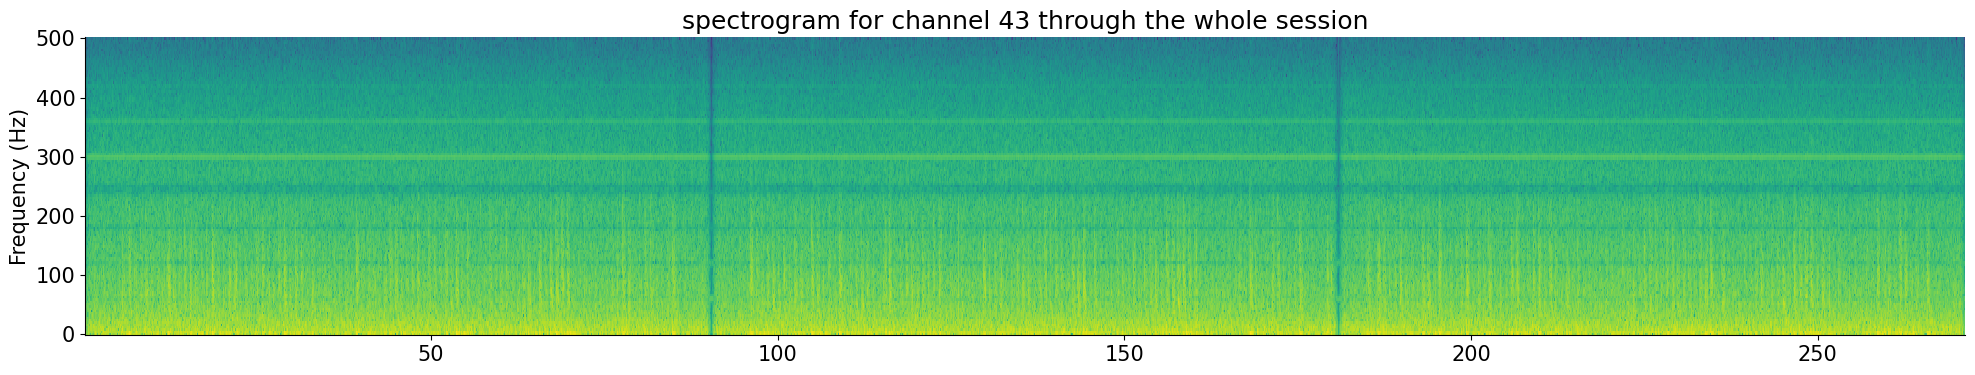

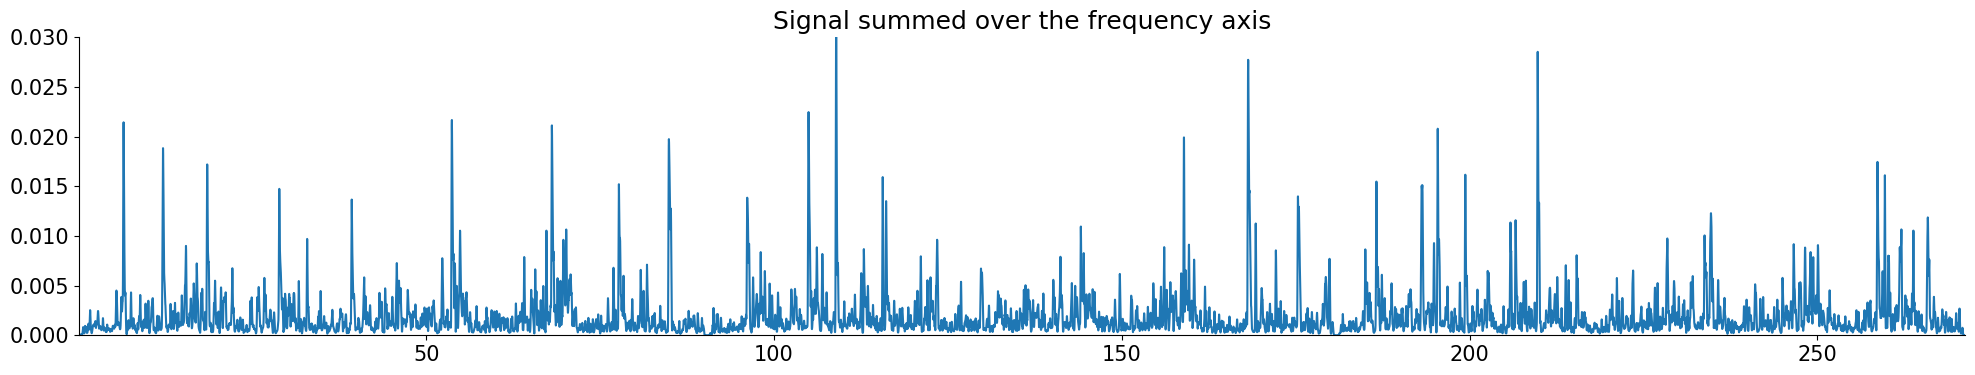

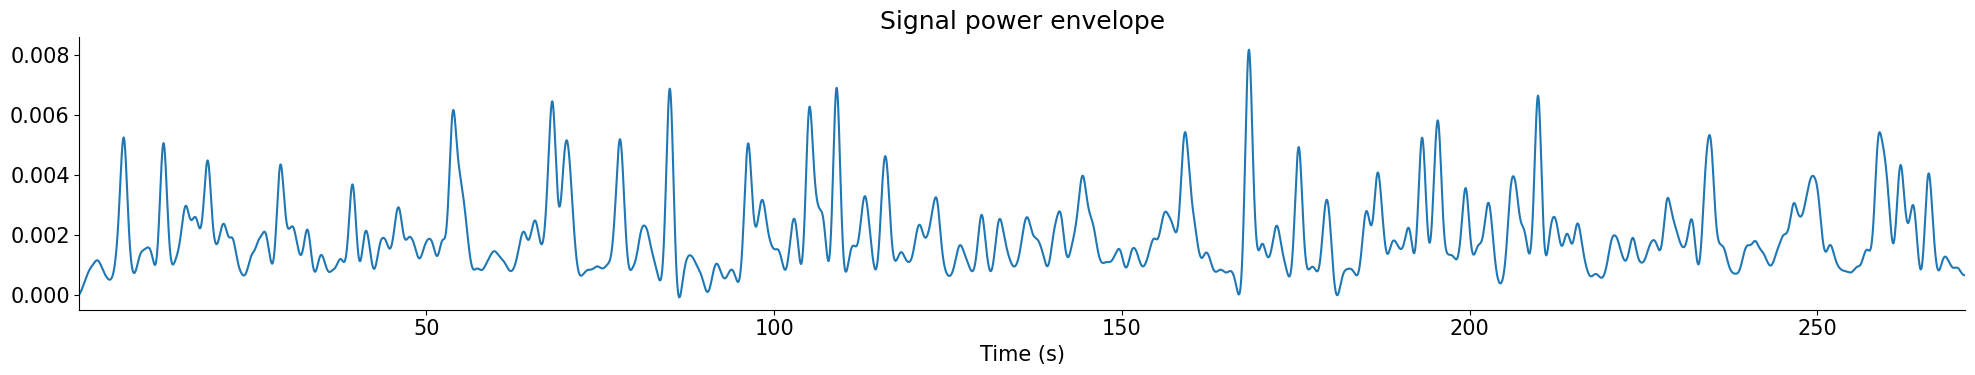

In [ ]:
#@title Spectrogram
#@markdown One powerful tool for spectral analysis is the spectrogram. The lighter colors represent a stronger signal. The horizontal lines are artifacts from the ECoG hardware, typically around ~ 60Hz and multiples. The vertical lines that can be seen in the range from 50 to 200 shows that this channel was very sensitive to the stimuli. The signal summed over the frequency axis is an alternative representation of the power of the signal. Low-pass filters can also be used as a way to catch the envelope of a signal.

#plt.figure(figsize=(20, 6))
plt.title('spectrogram for channel 43 through the whole session')
Pxx, freqs, bins, im = plt.specgram(V[:,43],NFFT=2**8,noverlap=2**8-10,Fs=1000)
plt.pcolormesh(bins, freqs, 10*np.log10(Pxx))
plt.ylabel('Frequency (Hz)')
plt.show()

plt.title('Signal summed over the frequency axis')
summed_over_frequency_signal = Pxx.mean(0)
plt.plot(bins,summed_over_frequency_signal)
plt.xlim([min(bins),max(bins)])
plt.ylim([0,0.03])
plt.show()

plt.title('Signal power envelope')
b, a = signal.butter(3, [5], btype = 'low', fs=1000)
envelope = signal.filtfilt(b,a,summed_over_frequency_signal,0)
plt.plot(bins,envelope)
plt.xlabel('Time (s)')
plt.xlim([min(bins),max(bins)])
plt.show()

In [ ]:
#@title Calculate event-locked spectrogram for channel 43
nt, nchan = V.shape
nstim = len(dat1['t_on'])

downsampled_t_on = np.round(dat1['t_on']*len(bins)/len(V[:,0]))
trange = np.arange(-20, 40)
ts = downsampled_t_on[:,np.newaxis] + trange

Pxx_separated_by_events = np.zeros([300,129,60])

for event in tqdm(range(nstim)):
    timerange_event = ts[event].astype(int)
    Pxx_event = Pxx[:,timerange_event]
    Pxx_separated_by_events[event] = Pxx_event

Pxx_house = (Pxx_separated_by_events[dat1['stim_id']<=50]).mean(0)
Pxx_face  = (Pxx_separated_by_events[dat1['stim_id']>50]).mean(0)

  0%|          | 0/300 [00:00<?, ?it/s]

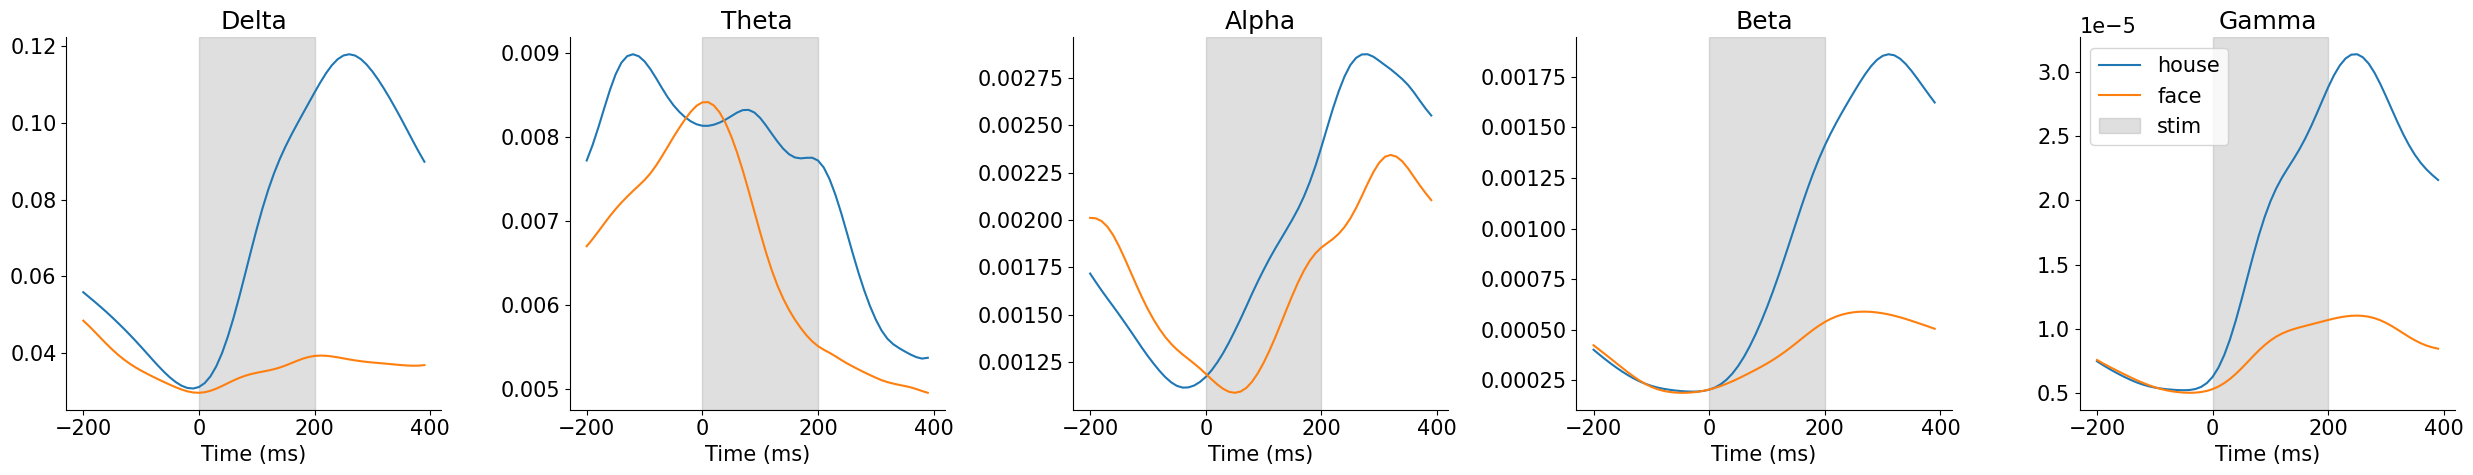

In [ ]:
#@title Calculate power of event-locked potential but for specific frequency ranges in channel 43
#@markdown With the spectrogram, you can filter specific frequencies by just selecting a specific range in the y-axis. It is important to note, however, that the spectrogram is smoothed accross different frequencies, because it is calculated using a discrete fourier transform. It means that there might be some frequency bands "spilling" over to the others. To ensure no such "leakage" of one band to the other, it is recommended to implement a similar algorithm with a [discrete wavelet transform](https://pywavelets.readthedocs.io/en/latest/ref/dwt-discrete-wavelet-transform.html) instead.

trange_event = np.arange(-200,400,10)

plt.figure(figsize=(25, 5))
plt.subplot(1,5,1)
plt.title('Delta')
summed_over_frequency_signal = Pxx_house[0:4,:].mean(0)
plt.plot(trange_event,summed_over_frequency_signal)
summed_over_frequency_signal = Pxx_face[0:4,:].mean(0)
plt.plot(trange_event,summed_over_frequency_signal)
plt.axvspan(0,200, color='0.5', alpha=0.25)
plt.xlabel('Time (ms)')

plt.subplot(1,5,2)
plt.title('Theta')
summed_over_frequency_signal = Pxx_house[4:8,:].mean(0)
plt.plot(trange_event,summed_over_frequency_signal)
summed_over_frequency_signal = Pxx_face[4:8,:].mean(0)
plt.plot(trange_event,summed_over_frequency_signal)
plt.axvspan(0,200, color='0.5', alpha=0.25)
plt.xlabel('Time (ms)')

plt.subplot(1,5,3)
plt.title('Alpha')
summed_over_frequency_signal = Pxx_house[8:12,:].mean(0)
plt.plot(trange_event,summed_over_frequency_signal)
summed_over_frequency_signal = Pxx_face[8:12,:].mean(0)
plt.plot(trange_event,summed_over_frequency_signal)
plt.axvspan(0,200, color='0.5', alpha=0.25)
plt.xlabel('Time (ms)')

plt.subplot(1,5,4)
plt.title('Beta')
summed_over_frequency_signal = Pxx_house[12:30,:].mean(0)
plt.plot(trange_event,summed_over_frequency_signal)
summed_over_frequency_signal = Pxx_face[12:30,:].mean(0)
plt.plot(trange_event,summed_over_frequency_signal)
plt.axvspan(0,200, color='0.5', alpha=0.25)
plt.xlabel('Time (ms)')

plt.subplot(1,5,5)
plt.title('Gamma')
summed_over_frequency_signal = Pxx_house[30:,:].mean(0)
plt.plot(trange_event,summed_over_frequency_signal,label='house')
summed_over_frequency_signal = Pxx_face[30:,:].mean(0)
plt.plot(trange_event,summed_over_frequency_signal,label='face')
plt.axvspan(0,200, color='0.5', alpha=0.25,label='stim')
plt.xlabel('Time (ms)')
plt.legend()
plt.show()

Other interesting techniques of spectral analysis are cross spectral coherence, etc.

# Decoding of input stimuli



I tried to decode the input stimulus class (face or house) from single electrodes. So far, I've use the simplest tools:
* logistic regression with L2 penalty;
* no broadband filter;
* validation by splitting the data into train and test sets.

This can obviously be done more nicely (filter, cross validation, SVMs, ...).

I used small intervals of the channels locked to the stimulus onset times as
input data for the classifier. The label is the stimulus identity. The decoder has a weight for each time point of the input data (so that the decoder width depends on the length of the interval).  

The decoding accuracy gives some intuition about how informative each channel is for decoding (apart from overfitting issues...). Furthermore, one can try to interprete the decoding weights, asking for example:
* At which time point the decoder starts to use the input.
* Do different channels use different time points?
* etc.

In [ ]:
#@title Load data and define variables
# Load voltage dataset (e.g. faces house)
dat1, _ = load_data('faceshouses', patient_id=1)

# Define variables
# Voltage data: times x channel
V = dat1['V']
n_t, n_ch = V.shape
channels = np.arange(n_ch)
# Times
srate = dat1['srate'].squeeze()
t_all = np.arange(n_t) #/ srate
t_on = dat1['t_on'] #/ srate
t_off = dat1['t_off'] #/ srate
# print("Min and max time / s:", t_all.min(), t_all.max())
# Stimulus identities
n_stim = len(t_on)
stim_id = dat1['stim_id']
n_stim_id = stim_id.max() - stim_id.min()
# 1-50 for houses, 51-100 for faces
n_stim_g = n_stim_id//2 + 1
id_max_house = 50

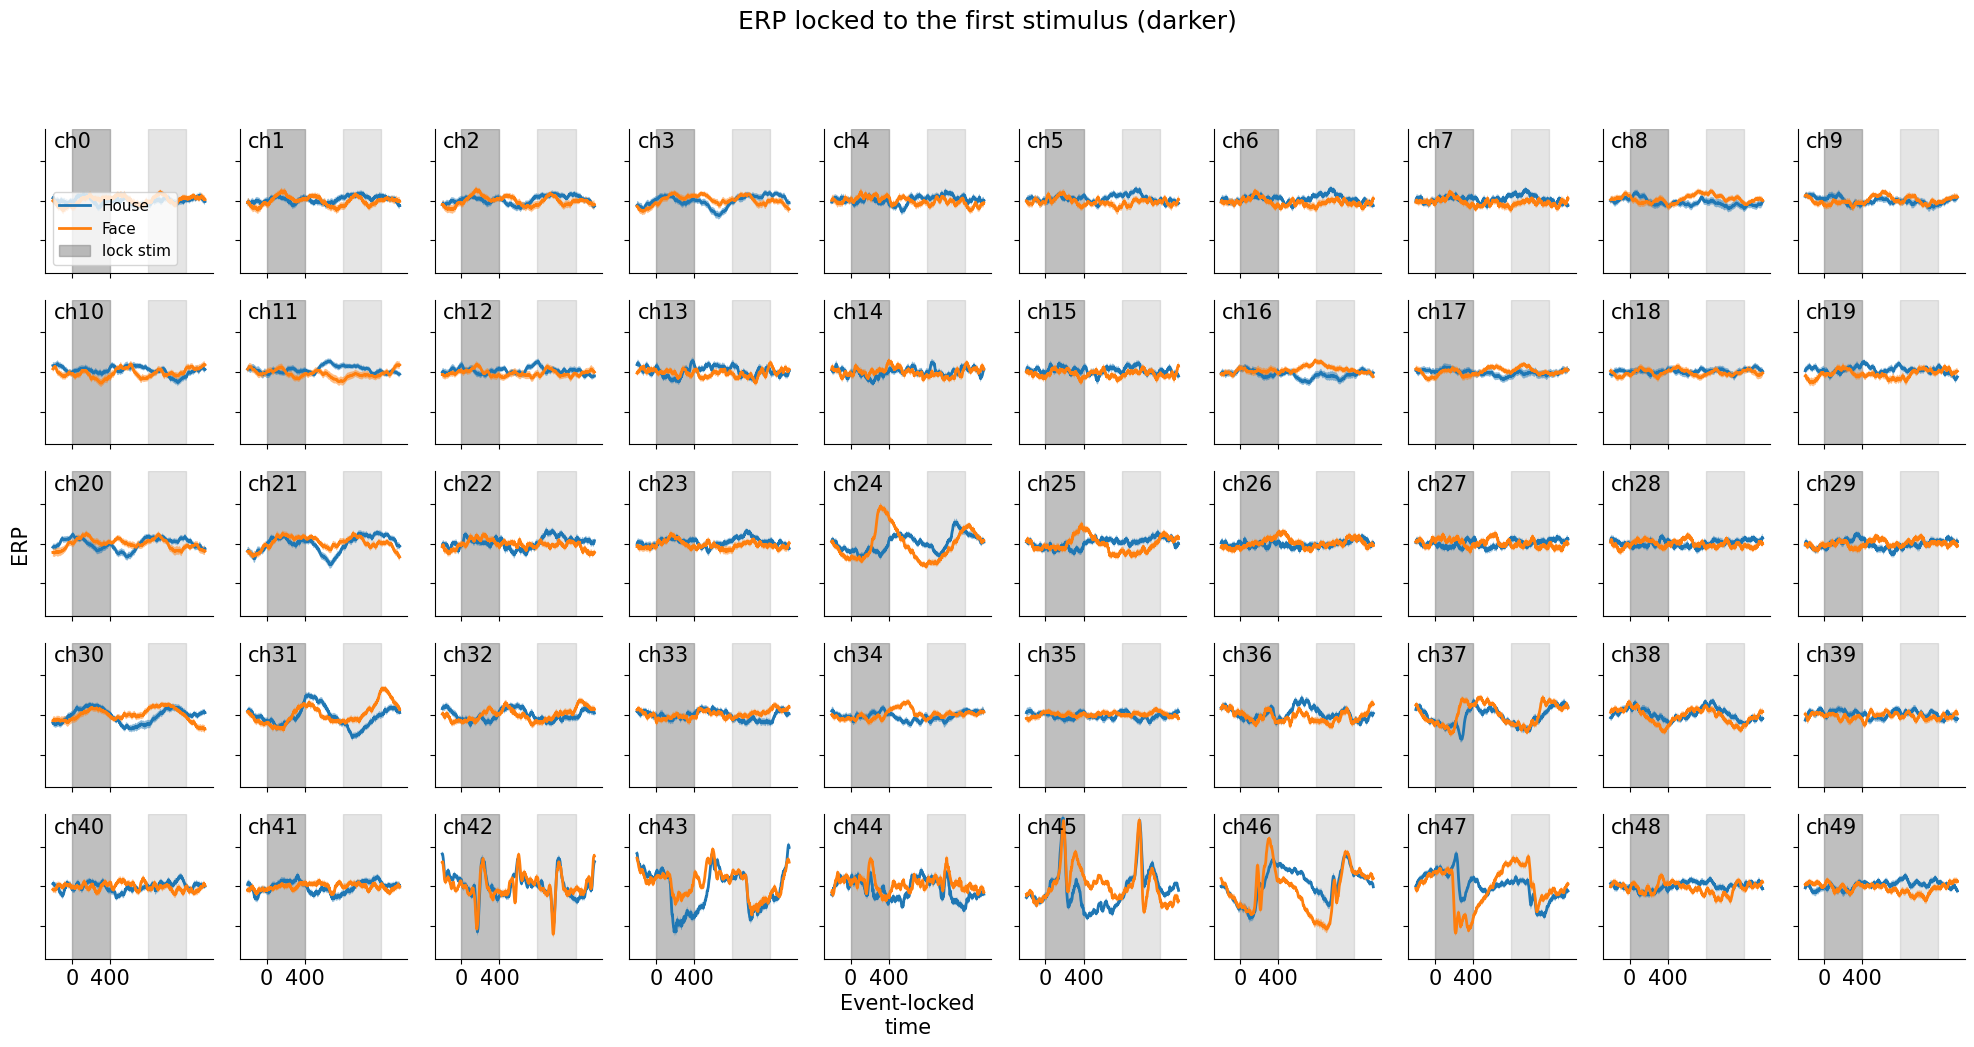

In [ ]:
#@title Event-locked average raw potential (ERP)
# Stimulus duration
t_stim_on = np.unique(np.round(t_off - t_on, 5))
assert len(t_stim_on) == 1, "Not all stimulus intervals are equal"
t_stim_on = t_stim_on[0]
# Inter-stimulus intervals (ISIs)
t_isi = np.unique(np.round(t_on[1:] - t_off[:-1], 5))
# There are 3 blocks of input stimuli. Choose the shortes ISI to avoid
# the block transition.
t_isi = t_isi.min()

# Choose the time interval for each sample:
# Start 1/2 ISI before the stimulus, and extend beyond the next stimulus.
# It appears that for some channels, one can still decode the first stimulus
# while the next one is given. *???*
n_cyc = 2     # how many cycles of input + ISI
t_erp = np.int_(np.arange(n_cyc * (t_stim_on + t_isi)) - t_isi//2)
n_t_erp = len(t_erp)
# Take all time points around stimulus onsets.
t_erp_all = t_on[:, None] + t_erp[None, :]
# Corresponding volages
V_erp = V[t_erp_all]
V_house = V_erp[stim_id <= id_max_house]
V_face  = V_erp[stim_id > id_max_house]

# Event-locked average raw potential (ERP)
def plot_erp():
    """ Plot ERP. """
    fig = plt.figure(figsize=(20,10))
    n_rows = 5
    n_cols = 10
    sharey=True
    axes = fig.subplots(n_rows, n_cols, sharex=True, sharey=sharey)
    for i_ch in range(min(n_ch, n_rows*n_cols)):
        if sharey:
            ymax = np.abs(V_erp).mean(0).max() * 1.05
        i_r = i_ch // n_cols
        i_c = i_ch % n_cols
        ax = axes[i_r, i_c]
        for i_hf, V_hf in enumerate([V_house, V_face]):
            y = V_hf[:, :, i_ch]
            lbl = ["House", "Face"][i_hf]
            ym = y.mean(0)
            ax.plot(t_erp, ym, lw=2, label=lbl)
            # Plot standard error
            ys = y.std(0) / np.sqrt(len(y))
            ax.fill_between(t_erp, ym-ys, ym+ys, alpha=0.5)
        # Show stimuli
        for i in range(n_cyc):
            t_on_i = i * (t_stim_on + t_isi)
            t_off_i = i * (t_stim_on + t_isi) + t_stim_on
            alpha = 0.5 if i == 0 else 0.2
            lbl = "lock stim" if i == 0 else None
            ax.axvspan(t_on_i, t_off_i, color='0.5', alpha=alpha, zorder=-1,
                    label=lbl)
        if i_ch == 0:
            ax.legend(loc=3, fontsize=11, )
        # Polish
        ax.text(0.05, 0.98, "ch%d"%i_ch, ha='left', va='top',
                transform=ax.transAxes)
        ax.set_xticks([0, t_stim_on])
        if i_r == n_rows-1 and i_c == n_cols//2-1:
            ax.set_xlabel("Event-locked\ntime")
        # y axes
        ax.set_ylim(-ymax, ymax)
        ax.set_yticklabels([])
        if i_r == n_rows//2 and i_c == 0:
            ax.set_ylabel("ERP")
    fig.suptitle("ERP locked to the first stimulus (darker)", y=1.05)
    fig.tight_layout()
plot_erp()

Top test acc: 0.91 for channel 47


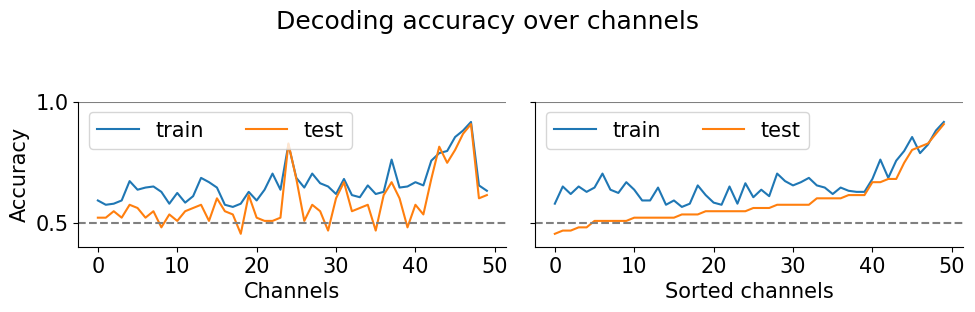

In [ ]:
#@title Fit a linear classifier for each channel
def fit_clf():
    # Split data into train and test set
    from sklearn.model_selection import train_test_split
    test_size = 0.25
    # Target classes
    is_house = stim_id <= id_max_house
    idx_train, idx_test, y_train, y_test = train_test_split(
        np.arange(n_stim), is_house, test_size=test_size, random_state=0)
    # Fit logistic regression with regularization.
    from sklearn.linear_model import LogisticRegression
    log_reg = LogisticRegression(penalty='l2', C=0.0001)
    # Iterate over all channels
    n_tt = 2    # test and train
    acc_all = np.zeros((n_ch, n_tt))
    weights_all = np.zeros((n_ch, n_t_erp))
    for i_ch in range(n_ch):
        X_train = V_erp[idx_train, :, i_ch]
        X_test = V_erp[idx_test, :, i_ch]
        log_reg.fit(X_train, y_train)
        # Performance on test set
        acc_train = (log_reg.predict(X_train) == y_train).mean()
        acc_test = (log_reg.predict(X_test) == y_test).mean()
        # Save
        acc_all[i_ch, 0] = acc_train
        acc_all[i_ch, 1] = acc_test
        weights_all[i_ch] = log_reg.coef_[0]
    return acc_all, weights_all

acc_all, weights_all = fit_clf()
# Sort channels by accuracy
acc_sorter = np.argsort(acc_all[:, 1])
print("Top test acc: %.2f for channel %d" % (
    acc_all[acc_sorter, 1][-1], acc_sorter[-1]))

def plot_acc_ch():
    fig = plt.figure(figsize=(10, 3))
    axes = fig.subplots(1, 2, sharex=True, sharey=True)
    # Unsorted channels
    ax = axes[0]
    ax.plot(acc_all[:, 0], label='train')
    ax.plot(acc_all[:, 1], label='test')
    ax.axhline(0.5, ls='--', c=c_leg)#, label='chance')
    ax.axhline(1., ls='-', c=c_leg)
    ax.legend(loc=2, ncol=2)
    ax.set_ylabel("Accuracy")
    ax.set_yticks([0.5, 1.])
    ax.set_ylim(0.4, 1.)
    ax.set_ylabel("Accuracy")
    ax.set_yticks([0.5, 1.])
    ax.set_xlabel("Channels")
    # Sort along test accuracy
    ax = axes[1]
    ax.plot(acc_all[acc_sorter, 0], label='train')
    ax.plot(acc_all[acc_sorter, 1], label='test')
    ax.axhline(0.5, ls='--', c=c_leg)#, label='chance')
    ax.set_xlabel("Sorted channels")
    ax.axhline(1., ls='-', c=c_leg)
    ax.legend(loc=2, ncol=2)
    fig.suptitle("Decoding accuracy over channels", y=1.05)
plot_acc_ch()

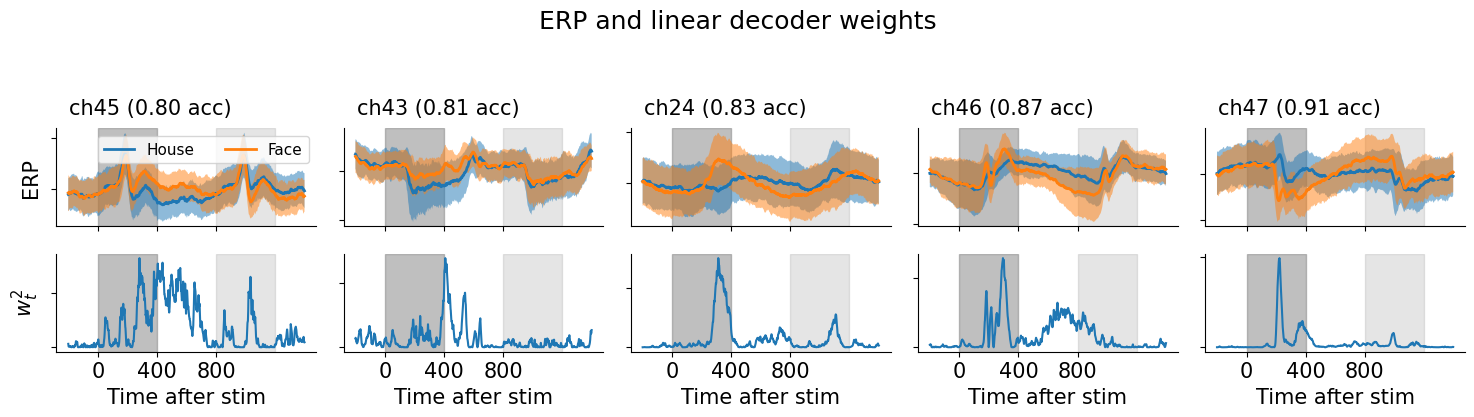

In [ ]:
#@title Plot weights at corresponding times
def plot_weights():
    i_ch_show = acc_sorter[-5:]
    fig = plt.figure(figsize=(15,4))
    n_rows = 2
    n_cols = len(i_ch_show)
    axes = fig.subplots(n_rows, n_cols, sharex=True, sharey=False)
    for i_show, i_ch in enumerate(i_ch_show):
        # Trajectories
        ax = axes[0, i_show]
        single_traces = False
        for i_hf, V_hf in enumerate([V_house, V_face]):
            y = V_hf[:, :, i_ch]
            lbl = ["House", "Face"][i_hf]
            ym = y.mean(0)
            ax.plot(t_erp, ym, lw=2, label=lbl)
            if single_traces:
                # Plot single traces to get a feeling
                for y_i in y:
                    ax.plot(t_erp, y_i, lw=0.5, alpha=0.2, zorder=0)
            else:
                # Plot standard error
                ys = y.std(0) #/ np.sqrt(len(y))
                ax.fill_between(t_erp, ym-ys, ym+ys, alpha=0.5)
        # Show stimuli
        for i in range(n_cyc):
            for ax in axes[:, i_show]:
                t_on_i = i * (t_stim_on + t_isi)
                t_off_i = i * (t_stim_on + t_isi) + t_stim_on
                alpha = 0.5 if i == 0 else 0.2
                lbl = "lock stim" if i == 0 else None
                ax.axvspan(t_on_i, t_off_i, color='0.5', alpha=alpha, zorder=-1)
        # Polish
        ax = axes[0, i_show]
        if i_show == 0:
            ax.legend(loc=1, ncol=2, fontsize=11, )
            ax.set_ylabel("ERP")
        ax.set_yticklabels([])

        ### Weights
        ax = axes[1, i_show]
        ax.plot(t_erp, weights_all[i_ch]**2)
        ax.set_yticklabels([])
        if i_show == 0:
            ax.set_ylabel(r"$w_t^2$")
        # Polish
        for i_r in range(n_rows):
            ax = axes[i_r, i_show]
            ax.set_xticks([0, t_stim_on, t_stim_on + t_isi])
            if i_r == 0:
                ax.text(0.05, 1.1, "ch%d (%.2f acc)"%(i_ch, acc_all[i_ch, 1]),
                        ha='left',va='bottom', transform=ax.transAxes)
            if i_r == n_rows - 1:
                ax.set_xlabel("Time after stim")
        fig.suptitle("ERP and linear decoder weights", y=1.05)
        fig.tight_layout()
plot_weights()
